In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 10
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 100
BATCH_SIZE = 5
N_ITERATIONS = 10
NUM_RESTARTS = 20 
RAW_SAMPLES = 1024


R_mu = 20
R_sigma = 1e-2
SHAPE_PARAM = 0.67

expt = {}
EXPT_ID = 0

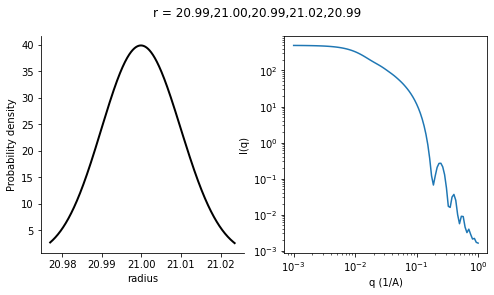

In [3]:
sim = head.EmulatorMultiShape()
sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

q, st = sim.get_saxs(shape_param = SHAPE_PARAM, n_samples=N_SAS_SAMPLES)
axs[1].loglog(q, st)
plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

In [4]:
# define search space
r_mu = [5,50]
r_sigma = [0,1]
shape_param = [0,1]
bounds = torch.tensor((r_mu, r_sigma, shape_param)).T.to(**tkwargs)

In [5]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()    
    sim.make_structure(r_mu=x_np[0],r_sigma=x_np[1])
    q, si = sim.get_saxs(x_np[2], n_samples=N_SAS_SAMPLES)
    dist_sas = euclidean_dist(np.log10(si),np.log10(st))
    expt[EXPT_ID] = [q, si, dist_sas]
    EXPT_ID += 1
    
    return torch.tensor([dist_sas])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [6]:
from botorch.utils.sampling import draw_sobol_samples

def draw_random_batch(n=6):
    train_x = draw_sobol_samples(
        bounds=bounds,n=1, q=n, 
        seed=torch.randint(2021, (1,)).item()
    ).squeeze(0)
    train_obj = batch_oracle(train_x)
    return train_x, train_obj

N_INIT_SAMPLES = 10
train_x, train_obj = draw_random_batch(n=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)
for i in range(N_INIT_SAMPLES):
    print('%d\t%s\t%s'%(i, train_x[i,...].numpy(), train_obj[i,...].numpy()))

Generated 10 samples randomly torch.Size([10, 3]) torch.Size([10, 1])
0	[26.75195873  0.86088985  0.72363967]	[-3.11499166]
1	[1.18323716e+01 2.01466959e-03 9.61144865e-02]	[-10.15731907]
2	[45.32708228  0.92120826  0.99861127]	[-5.76571178]
3	[26.23937786  0.93564725  0.76810813]	[-3.15327883]
4	[44.87282068  0.14418328  0.52729291]	[-5.71895075]
5	[20.58799163  0.26117662  0.80171251]	[-0.40569425]
6	[48.21223527  0.49209988  0.59131134]	[-6.14378929]
7	[15.49711935  0.99071431  0.27173284]	[-7.81926537]
8	[42.6153931   0.97315371  0.8074227 ]	[-5.53540468]
9	[48.98451835  0.74062717  0.56681347]	[-6.24906874]


In [7]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

# 3. Define acqusition function
obj = LinearMCObjective(weights=torch.tensor([1.0]).to(**tkwargs))


In [8]:
from botorch.optim.optimize import optimize_acqf


def selector(f, q = BATCH_SIZE):
    new_x, _ = optimize_acqf(
        acq_function=f,
        bounds=bounds,
        q=q,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, 
        sequential=False,
    )
    new_obj = batch_oracle(new_x)
    return new_x, new_obj

In [9]:
torch.manual_seed(2021)
import pdb

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
print('Sampled ID \t Locations \t Objectives')
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition module
    acquisition = qUpperConfidenceBound(model, beta=0.1, objective=obj)
    
    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)
    for i in range(BATCH_SIZE):
        print('%d\t%s\t%s'%(i, new_x[i,...].numpy(), new_obj[i,...].numpy()))

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # re-initialize
    mll, model = initialize_model(train_x, train_obj)

    best = train_obj.max(axis=0).values
    print('Best %.2f'%(best))

Sampled ID 	 Locations 	 Objectives
Iteration : 1/10
0	[25.21075059  0.06172679  0.20048933]	[-4.21451807]
1	[20.58799156  0.26117659  0.80171246]	[-0.51998234]
2	[27.61874036  0.30808596  0.52156567]	[-3.32962632]
3	[32.23629807  0.0687384   0.96889376]	[-4.01717329]
4	[23.46247945  0.16254481  0.30215832]	[-4.42839336]
Best -0.41
Iteration : 2/10
0	[20.51773876  0.24443241  0.81858559]	[-0.45298725]
1	[20.58771901  0.2199524   0.75587095]	[-0.65670615]
2	[22.34344194  0.61698685  0.1918252 ]	[-4.74003077]
3	[31.09999823  0.75987955  0.44543966]	[-4.0550108]
4	[24.76138928  0.0890863   0.97416302]	[-2.77115393]
Best -0.41
Iteration : 3/10
0	[20.59265982  0.25793602  0.90252818]	[-0.53713632]
1	[13.96293899  0.93879404  0.66115203]	[-3.41930962]
2	[20.5209335   0.32974875  0.84394564]	[-0.70670259]
3	[8.4579086  0.70205701 0.74566715]	[-6.21705008]
4	[27.07097065  0.54952627  0.80330489]	[-3.21658826]
Best -0.41
Iteration : 4/10
0	[32.59603703  0.58535415  0.83456664]	[-4.06734705]
1	[

ValueError: Domain error in arguments.

In [ ]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean
from botorch.acquisition.objective import ScalarizedObjective
objective = ScalarizedObjective(weights=torch.tensor([1.0]).to(**tkwargs))

print('Actual target : ', [R_mu, R_sigma])
opt_x, opt_obj = selector(PosteriorMean(model, objective=objective), q=1)
print('Optimal location: ',opt_x.numpy(),'\nOptimal model scores: ', opt_obj.numpy())

In [ ]:
batch_number = torch.cat(
    [torch.zeros(N_INIT_SAMPLES), 
     torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

for b in np.unique(batch_number):
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Batch number %d'%b)
    for i in np.argwhere(batch_number==b).squeeze():
        ax.loglog(expt[i][0], expt[i][1], label='%.2f'%expt[i][2])
    ax.legend()
    plt.show()